**ML PROBLEM 4.2**

**Ideias**

Devemos considerar y e a relação de x para y ao separar os dados. Porque todos os x podem ter a mesma estrutura, mas a diferença apenas estar nos resultados y. Uma vez que o facto de aplicarmos modelos linares diferentes aos dados x, apenas faz variar os valores de y

Para isso podemos tentar usar um clustering que use x e y, dando especial relavância a y. Ou então passar para supervised learning.
(métodos que devem ser adequados K-Means or Gaussian Mixture Models)

No caso de supervised learning, o chatgpt diz dois modelos possiveis:

Multi-Output Regression:
In this approach, you treat the problem as a multi-output regression problem where you predict multiple target values simultaneously. In your case, you can predict both the target values for the first model and the target values for the second model in a single model.
Common algorithms for multi-output regression include MultiOutputRegressor in scikit-learn or using multi-layer neural networks with multiple output nodes.

Multi-Task Learning (MTL):
Multi-task learning is a technique where a single model is trained to perform multiple related tasks. In your case, the tasks are to predict y values for both models.
You can design a neural network architecture where the last layer has two output nodes, one for each model's target values. The earlier layers can capture the shared features between the two models, allowing the model to learn the common underlying structure.
You can use techniques like weight sharing or auxiliary tasks to encourage the model to learn shared representations.



In [1]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LassoCV, Lasso
from sklearn import linear_model 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from math import *
import warnings
import os
from sklearn import preprocessing
from sklearn.model_selection import cross_validate
from sklearn.metrics import r2_score

 


warnings.filterwarnings("ignore")


**Loading the data from the files given**

In [2]:
# Loading the data from the files given

X_train = np.load(os.path.abspath('X_train_regression2.npy'))
y_train = np.load(os.path.abspath('y_train_regression2.npy'))
X_test  = np.load(os.path.abspath('X_test_regression2.npy'))

**Normalization and Clustering of the data**

Não concordo com o método acima - escrito por Alexandre
Não concordo porque os modelos diferentes que temos são aplicados a x e produzem y. Logo o modelo só faz variar o y. Se queremo saber quais dos dados é que tiveram cada modelo aplicado, temos de analisar também os y

**Kmeans com x e Y**

In [3]:
from sklearn.cluster import KMeans
kmeans_xy = KMeans(n_clusters = 2, random_state = 0, n_init='auto')

X_Y_Train = np.hstack((X_train,y_train))
X_Y_train_norm = preprocessing.normalize(X_Y_Train) 

kmeans_xy.fit(X_Y_Train)
model1_indices_xy =  [ind for ind, x in enumerate((kmeans_xy.labels_).tolist()) if x == 1]


X_train_model0_xy = X_train.copy()
X_train_model1_xy = X_train.copy()
y_train_model0_xy = y_train.copy()
y_train_model1_xy = y_train.copy()


X_train_model0_xy = np.delete(X_train_model0_xy, model1_indices_xy, 0)
y_train_model0_xy = np.delete(y_train_model0_xy, model1_indices_xy, 0)


X_train_model1_xy = X_train[model1_indices_xy,:]
y_train_model1_xy = y_train[model1_indices_xy,:]



Gausian

In [4]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=2, random_state=0).fit(X_Y_Train)
pred = gm.predict(X_Y_Train)

model1_indices_xy_gm =  [ind for ind, x in enumerate(pred) if x == 1]


X_train_model0_xy_gm = X_train.copy()
X_train_model1_xy_gm = X_train.copy()
y_train_model0_xy_gm = y_train.copy()
y_train_model1_xy_gm = y_train.copy()


X_train_model0_xy_gm = np.delete(X_train_model0_xy_gm, model1_indices_xy_gm, 0)
y_train_model0_xy_gm = np.delete(y_train_model0_xy_gm, model1_indices_xy_gm, 0)


X_train_model1_xy_gm = X_train[model1_indices_xy_gm,:]
y_train_model1_xy_gm = y_train[model1_indices_xy_gm,:]

        

Funções de regressão por ridge com cálculo de r^2 e mse

In [47]:
def Ridge_func(x, y, cv_value):
    ridge = linear_model.RidgeCV(alphas=np.arange(0.01,10,0.5), scoring="neg_mean_squared_error", cv=cv_value).fit(x,y)    
    cv_results = cross_validate(ridge, x, y,scoring='neg_mean_squared_error', cv=cv_value)
    neg_mean_squared_errors = cv_results['test_score']
    MSE = np.mean(neg_mean_squared_errors)

    return MSE



def RidgeCv_otimization(x,y, fit_intercept_bool, cv_value_max):
    RidgeOptimization_model_parameters = np.empty([0,4])
    #we are going to test every possible value for k-fold cross validation including k=15 which is equivalent to the efficient Leave One Out method

    for cv_value in np.arange(2,cv_value_max+1,1):
        RidgeOptimization_model = linear_model.RidgeCV(alphas=np.arange(0.01,10,0.1), fit_intercept=fit_intercept_bool, scoring="r2", cv=cv_value).fit(x, y)
        
        cv_results = cross_validate(RidgeOptimization_model, x, y,scoring='neg_mean_squared_error', cv=cv_value_max+1)

        neg_mean_squared_errors = cv_results['test_score']
        mean_neg_mean_squared_error = np.mean(neg_mean_squared_errors)

        y_pred = RidgeOptimization_model.predict(x)

        
        r_cv_squared = r2_score(y, y_pred)

        RidgeOptimization_model_parameters = np.vstack((RidgeOptimization_model_parameters, np.array([cv_value , RidgeOptimization_model.alpha_, mean_neg_mean_squared_error, r_cv_squared])))
    MSE_otimization_2(RidgeOptimization_model_parameters)
    return(RidgeOptimization_model_parameters)

def MSE_otimization_2(matrix_cv_alpha_score):
    i = np.argmax(matrix_cv_alpha_score[:,2])
    print("The values that optimize the mean squared error are  ")
    print("Ridge Alpha " + str(matrix_cv_alpha_score[i,1]))
    print("Cv for least MSE  " + str(matrix_cv_alpha_score[i,0]))
    print("For a MSE  " + str(matrix_cv_alpha_score[i,2]))
    #print("MSE calculated via ridgecv - with fewer coluns in x=" + str(matrix_cv_alpha_score[i,2]))
    print('R^2  ' + str(matrix_cv_alpha_score[i,3]))
     





Modelo de regressão linear para todos os dados

In [48]:
print('Para todos os dados \n ')

Ridge_parameters_all = RidgeCv_otimization(X_train,y_train,True,14)

print('\n \nPara o modelo 0 - kmens \n')
Ridge_parameters_kmeans0 = RidgeCv_otimization(X_train_model0_xy,y_train_model0_xy,True,14)

print('\n \nPara o modelo 1 - kmens \n')
Ridge_parameters_kmeans1 = RidgeCv_otimization(X_train_model1_xy,y_train_model1_xy,True,14)

print('\n \nPara o modelo 0 GMM\n')
Ridge_parameters_gm0 = RidgeCv_otimization(X_train_model0_xy_gm,y_train_model0_xy_gm,True,14)

print('\n \nPara o modelo 1 GMM\n')
Ridge_parameters_gm1 = RidgeCv_otimization(X_train_model1_xy_gm,y_train_model1_xy_gm,True,14)


Para todos os dados 
 
The values that optimize the mean squared error are  
Ridge Alpha 9.91
Cv for least MSE  6.0
For a MSE  -1.3580072400952414
R^2  0.2980538691391533

 
Para o modelo 0 - kmens 

The values that optimize the mean squared error are  
Ridge Alpha 9.91
Cv for least MSE  14.0
For a MSE  -0.6668601574625422
R^2  0.2600275790960508

 
Para o modelo 1 - kmens 

The values that optimize the mean squared error are  
Ridge Alpha 9.91
Cv for least MSE  2.0
For a MSE  -0.5316370780874107
R^2  0.1949153508375434

 
Para o modelo 0 GMM

The values that optimize the mean squared error are  
Ridge Alpha 0.01
Cv for least MSE  6.0
For a MSE  -0.05423342046793682
R^2  0.9715035608558902

 
Para o modelo 1 GMM

The values that optimize the mean squared error are  
Ridge Alpha 0.11
Cv for least MSE  6.0
For a MSE  -0.0380634146199065
R^2  0.9805077021041371


**Resultado do codigo anterior guardado**
Para todos os dados 
 
The values that optimize the mean squared error are:
Ridge Alpha 9.51
Cv for least MSE6.0
For a MSE=-1.3572364288447052
R^2  0.2982846273721469

 
Para o modelo 0

The values that optimize the mean squared error are:
Ridge Alpha 9.51
Cv for least MSE10.0
For a MSE=-0.6662498966955057
R^2  0.2606623865286021

 
Para o modelo 1

The values that optimize the mean squared error are:
Ridge Alpha 9.51
Cv for least MSE2.0
For a MSE=-0.5320787420658964
R^2  0.19539112686604343

 
Para o modelo 0 GMM

The values that optimize the mean squared error are:
Ridge Alpha 0.01
Cv for least MSE6.0
For a MSE=-0.054203967258250975
R^2  0.9715035608558902

 
Para o modelo 1 GMM

The values that optimize the mean squared error are:
Ridge Alpha 0.01
Cv for least MSE3.0
For a MSE=-0.03812143480853756
R^2  0.980517166751606

Daqui concluímos que:
- O melhor método é usar o Gausian para separar os dados que foram criados com cada um dos dois modelos
- A partir destes dados, devemos usar um modelo ridge com alpha=0,01 para obter o melhor fit para os dados

In [46]:
print('modelo 0')
print(Ridge_parameters_gm0)
print('modelo 1')
print(Ridge_parameters_gm1)





[[ 2.00000000e+00  5.10000000e-01 -5.44852884e-02  9.71418444e-01]
 [ 3.00000000e+00  1.00000000e-02 -5.47880466e-02  9.71503561e-01]
 [ 4.00000000e+00  1.00000000e-02 -5.47394546e-02  9.71503561e-01]
 [ 5.00000000e+00  1.00000000e-02 -5.43845589e-02  9.71503561e-01]
 [ 6.00000000e+00  1.00000000e-02 -5.42039673e-02  9.71503561e-01]
 [ 7.00000000e+00  1.00000000e-02 -5.43845589e-02  9.71503561e-01]
 [ 8.00000000e+00  1.00000000e-02 -5.48570396e-02  9.71503561e-01]
 [ 9.00000000e+00  1.00000000e-02 -5.43845589e-02  9.71503561e-01]
 [ 1.00000000e+01  1.00000000e-02 -5.48280280e-02  9.71503561e-01]
 [ 1.10000000e+01  1.00000000e-02 -5.43845589e-02  9.71503561e-01]
 [ 1.20000000e+01  1.00000000e-02 -5.43845589e-02  9.71503561e-01]
 [ 1.30000000e+01  1.00000000e-02 -5.47038150e-02  9.71503561e-01]
 [ 1.40000000e+01  1.00000000e-02 -5.43845589e-02  9.71503561e-01]]
modelo 1
[[ 2.00000000e+00  5.10000000e-01 -3.82976550e-02  9.80317967e-01]
 [ 3.00000000e+00  1.00000000e-02 -3.81214348e-02  9

In [51]:
def prediction_ridge(x,y, fit_intercept_bool, xtest):
    ridge = linear_model.RidgeCV(alphas=np.arange(0.01,10,0.1), fit_intercept=fit_intercept_bool, scoring="neg_mean_squared_error", cv=6).fit(x, y)
    ytest = ridge.predict(xtest)
    return ytest

**Entrega**

In [52]:
y_test_model0_gm=prediction_ridge(X_train_model0_xy_gm,y_train_model0_xy_gm,True, X_test)
y_test_model1_gm=prediction_ridge(X_train_model1_xy_gm,y_train_model1_xy_gm,True, X_test)


prediction = np.transpose(np.vstack((y_test_model0_gm,y_test_model1_gm)))
#np.save('prediction_100123_100260_4.2',prediction)

**Anexos**

**Comparison of the predictions given by Model 0 and Model 1**

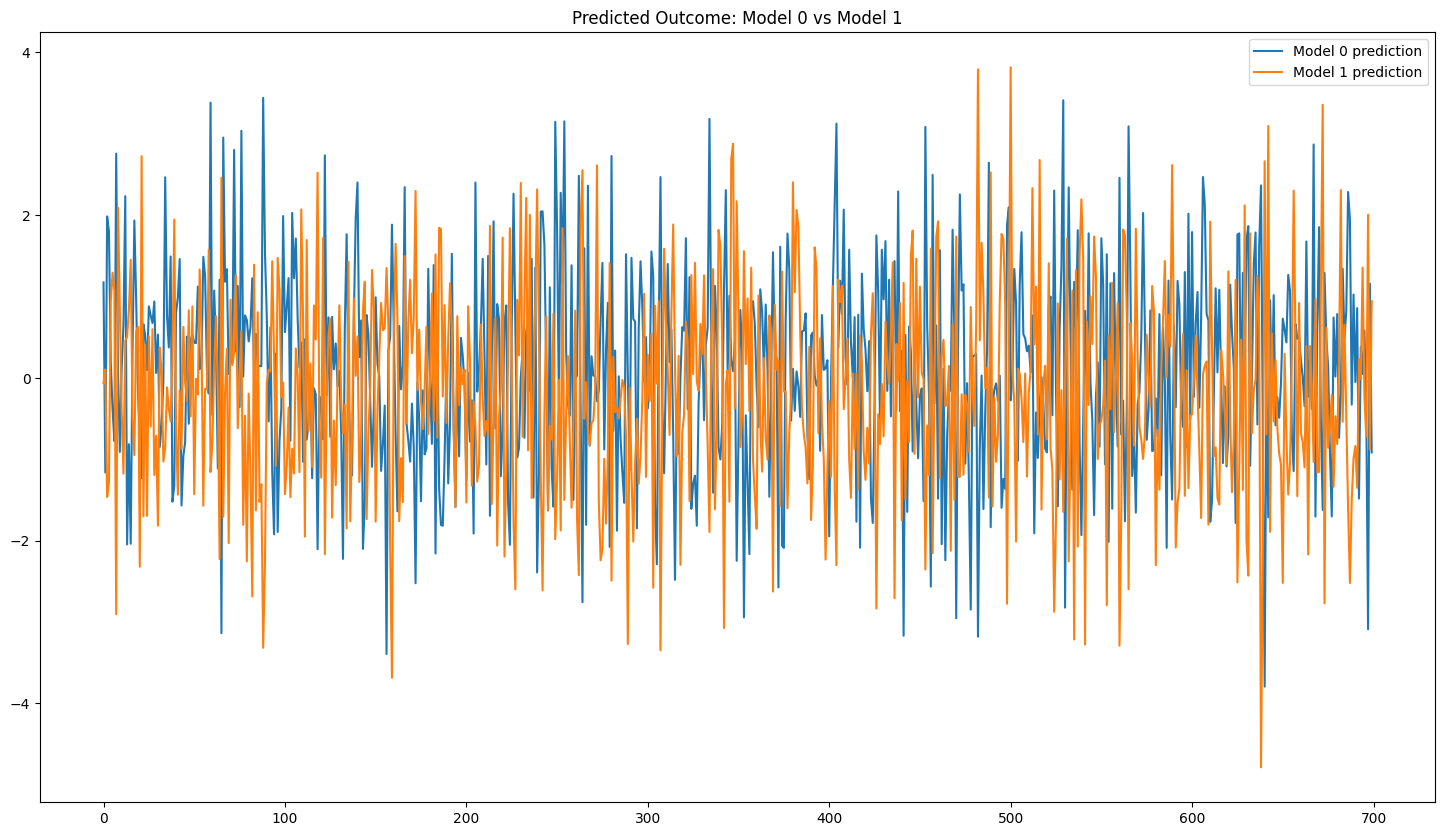

In [53]:
# Plotting the results
plt.figure(figsize=(18,10))
plt.plot(y_test_model0_gm[0:700],label='Model 0 prediction')
plt.plot(y_test_model1_gm[0:700],label='Model 1 prediction')

plt.title('Predicted Outcome: Model 0 vs Model 1')
plt.legend()


**Ideia computacionalmente exigente:**

ir a todas as combinações de 50, ver qual é o com menor MSE

dessa combinação de 50, tirar os que estão com maior erro

extrapolar/testar para os outros 50 e ver quais é que têm erro baixo

não faz muito sentido aplicar isto como está

**Ideia melhorada a nível computacional**
Ir aos primeiros 50 dados e treinar um modelo
Ver quais os dados que mais colaboram para o SSE e retirá-los
Aplicar o modelo treinado com os dados que sobrarem para os outros 50 dados e escolher os que têm erros mais pequenos em relação ao valor de y

Falta acabar de este segundo modelo!!

**Predictions**

In [ ]:
def prediction_lasso_ridge(x,y, X_test cvLasso, cvRidge):
    X_train_mean  = np.mean(x,axis=0) 
    y_train_mean  = np.mean(y,axis=0)

    X_train_prime = x.copy()
    y_train_prime = y.copy()

    for i in range(x.shape[1]):
        X_train_prime[:,i] = X_train_prime[:,i] -  X_train_mean[i]

    # y_train_prime is a one dimensional array, and as such we do not include it in the for loop 
    y_train_prime = y_train_prime - y_train_mean



    LassoModelCV = LassoCV(alphas=np.arange(0,10,0.01),cv=cvLasso,fit_intercept=False,random_state=0).fit(X_train_prime, y_train_prime) 
    beta_hat_lasso  = LassoModelCV.coef_ # Beta Coefficients from the LASSO Regularization


    # Removal of the unnecessary columns from the X data
    X_train_prime_lasso_ridge = X_train_prime.copy()
    X_test_lasso_ridge_model = X_test.copy()
    for i in range(np.shape(beta_hat_lasso)[0]-1, -1, -1):
        if beta_hat_lasso[i]==0:
            X_train_prime_lasso_ridge = np.delete(X_train_prime_lasso_ridge, i, 1)
            X_test_lasso_ridge_model = np.delete(X_test_lasso_ridge_model, i, 1)
            X_train_mean = np.delete(X_train_mean, i, axis = 0)



    RidgeModel = linear_model.RidgeCV(alphas=np.arange(0.01,10,0.01), fit_intercept=False, scoring="neg_mean_squared_error", cv=cvRidge).fit(X_train_prime_lasso_ridge, y_train_prime)
    beta_hat_ridge= RidgeModel.coef_  # Beta Coefficients from the application of the Ridge Regularization to the Coefficients from the LASSO Regularization


    beta_zero_model = y_train_mean - np.matmul((X_train_mean),np.transpose(beta_hat_ridge))
    m = [beta_zero_model[0]]
    for k in range(((beta_hat_ridge).shape[1])):
            m.append(beta_hat_ridge[:,k][0])
    beta_hat_lasso_ridge_model = np.array(m)


    #To calculate a SSE:
    cv_results = cross_validate(RidgeModel, , y,scoring='neg_mean_squared_error', cv=LeaveOneOut())
    neg_mean_squared_errors = cv_results['test_score']
    mean_neg_mean_squared_error = np.mean(neg_mean_squared_errors)

    return X_test_lasso_ridge_model, beta_hat_lasso_ridge_model, mean_neg_mean_squared_error

    


In [ ]:
def Prediction_model(x_test_lasso_ridge, beta_hat_lasso_ridge):
    X_test_final_model = np.hstack((np.ones((1000,1)),x_test_lasso_ridge))
    prediction_model = np.matmul(X_test_final_model,beta_hat_lasso_ridge)
    prediciton_model = prediction_model.reshape(1000,1)
    return prediciton_model

**Prediction for model 0 and 1**

In [ ]:
X_test_lasso_ridge_model0, beta_hat_lasso_ridge_model0, mean_neg_mean_squared_error0 = prediction_lasso_ridge(X_train_model0,y_train_model0, X_test,  8, 5)

X_test_lasso_ridge_model1, beta_hat_lasso_ridge_model1, mean_neg_mean_squared_error1 = prediction_lasso_ridge(X_train_model1,y_train_model1, X_test, 8, 5)

**Prediction on X Test using model 0 and 1**


In [ ]:
prediciton_model0 = Prediction_model(X_test_lasso_ridge_model0, beta_hat_lasso_ridge_model0)

prediciton_model1 = Prediction_model(X_test_lasso_ridge_model1, beta_hat_lasso_ridge_model1)

<Axes: xlabel='Column3', ylabel='Column4'>

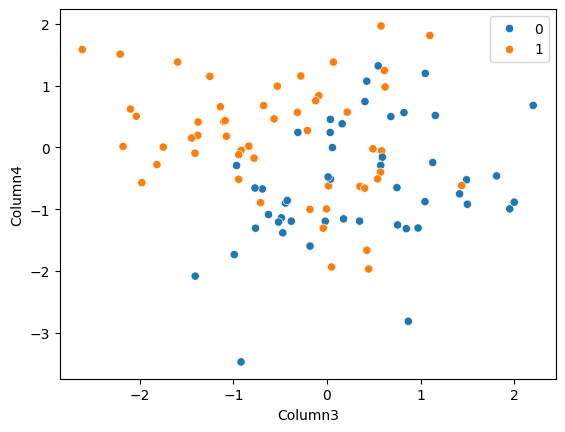

In [5]:
import seaborn as sns
df = pd.DataFrame(X_train, columns=['Column1', 'Column2', 'Column3','Column4'])
sns.scatterplot(data = df, x = 'Column3', y='Column4', hue = kmeans.labels_)

**Hipoteses para não termos tido mt bom na primeira task**



Ortogonal matching pursuit - experimentar este


In [ ]:
X_train_mean1  = np.mean(X_train_model1,axis=0) 
y_train_mean1  = np.mean(y_train_model1,axis=0)

X_train_prime1= X_train_model1.copy()
y_train_prime1 = y_train_model1.copy()

for i in range(X_train.shape[1]):
    X_train_prime1[:,i] = X_train_prime1[:,i] -  X_train_mean1[i]

# y_train_prime is a one dimensional array, and as such we do not include it in the for loop 
y_train_prime1 = y_train_prime1 - y_train_mean1 



LassoModelCV = LassoCV(alphas=np.arange(0,10,0.01),cv=15,fit_intercept=False,random_state=0).fit(X_train_prime1, y_train_prime1) 
LassoModel = Lasso(LassoModelCV.alpha_).fit(X_train_prime1, y_train_prime1) 
beta_hat_lasso  = LassoModel.coef_ # Beta Coefficients from the LASSO Regularization

# Removal of the unnecessary columns from the X data
X_train_prime_lasso_ridge1= X_train_prime1.copy()
X_test_lasso_ridge_model1 = X_test.copy()
for i in range(np.shape(beta_hat_lasso)[0]-1, -1, -1):
    if beta_hat_lasso[i]==0:
        X_train_prime_lasso_ridge1 = np.delete(X_train_prime_lasso_ridge1, i, 1)
        X_test_lasso_ridge_model1 = np.delete(X_test_lasso_ridge_model1, i, 1)
        X_train_mean1 = np.delete(X_train_mean1, i, axis = 0)



RidgeModel = linear_model.RidgeCV(alphas=np.arange(0.01,10,0.01), fit_intercept=False, scoring="neg_mean_squared_error", cv=5).fit(X_train_prime_lasso_ridge1, y_train_prime1)
beta_hat_ridge= RidgeModel.coef_  # Beta Coefficients from the application of the Ridge Regularization to the Coefficients from the LASSO Regularization


beta_zero_model1 = y_train_mean1 - np.matmul((X_train_mean1),np.transpose(beta_hat_ridge))
m = [beta_zero_model1[0]]
for k in range(((beta_hat_ridge).shape[1])):
        m.append(beta_hat_ridge[:,k][0])
beta_hat_lasso_ridge_model1 = np.array(m)



In [ ]:
X_train_mean0  = np.mean(X_train_model0,axis=0) 
y_train_mean0  = np.mean(y_train_model0,axis=0)

X_train_prime0 = X_train_model0.copy()
y_train_prime0 = y_train_model0.copy()

for i in range(X_train.shape[1]):
    X_train_prime0[:,i] = X_train_prime0[:,i] -  X_train_mean0[i]

# y_train_prime is a one dimensional array, and as such we do not include it in the for loop 
y_train_prime0 = y_train_prime0 - y_train_mean0 



LassoModelCV = LassoCV(alphas=np.arange(0,10,0.01),cv=8,fit_intercept=False,random_state=0).fit(X_train_prime0, y_train_prime0) 
LassoModel = Lasso(LassoModelCV.alpha_).fit(X_train_prime0, y_train_prime0) 
beta_hat_lasso  = LassoModel.coef_ # Beta Coefficients from the LASSO Regularization


# Removal of the unnecessary columns from the X data
X_train_prime_lasso_ridge0 = X_train_prime0.copy()
X_test_lasso_ridge_model0 = X_test.copy()
for i in range(np.shape(beta_hat_lasso)[0]-1, -1, -1):
    if beta_hat_lasso[i]==0:
        X_train_prime_lasso_ridge0 = np.delete(X_train_prime_lasso_ridge0, i, 1)
        X_test_lasso_ridge_model0 = np.delete(X_test_lasso_ridge_model0, i, 1)
        X_train_mean0 = np.delete(X_train_mean0, i, axis = 0)



RidgeModel = linear_model.RidgeCV(alphas=np.arange(0.01,10,0.01), fit_intercept=False, scoring="neg_mean_squared_error", cv=5).fit(X_train_prime_lasso_ridge0, y_train_prime0)
beta_hat_ridge= RidgeModel.coef_  # Beta Coefficients from the application of the Ridge Regularization to the Coefficients from the LASSO Regularization


beta_zero_model0 = y_train_mean0 - np.matmul((X_train_mean0),np.transpose(beta_hat_ridge))
m = [beta_zero_model0[0]]
for k in range(((beta_hat_ridge).shape[1])):
        m.append(beta_hat_ridge[:,k][0])
beta_hat_lasso_ridge_model0 = np.array(m)

 


In [ ]:
X_test_final_model1 = np.hstack((np.ones((1000,1)),X_test_lasso_ridge_model1))
prediction_model1 = np.matmul(X_test_final_model1,beta_hat_lasso_ridge_model1)
prediciton_model1 = prediction_model1.reshape(1000,1)

**Gaussian Mixture Model**


[1 1 1 0 1 0 0 0 0 0 1 1 1 0 0 1 1 1 0 0 0 1 1 1 1 1 0 1 0 1 0 1 0 1 1 1 1
 0 1 0 1 1 0 0 1 0 0 0 0 1 1 0 0 1 0 1 1 1 1 1 0 1 1 0 0 0 1 0 1 1 1 1 1 1
 0 0 0 1 1 0 0 0 1 1 1 0 0 1 1 1 1 0 1 1 1 1 0 1 1 0]


Devemos comparar os SSE's de cada clustering methods com o caso mais geral/simples, que neste caso é o Residual Analysis:
Modelos a usar:
1- K-means
2- K-means weigthed
3- Gaussian Mixture models 
4- Residual Analysis